In [1]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from JOPLEn.custom_trees import RegressionTree, VarMaxForest

In [2]:
np.random.seed(0)

x = np.random.randn(100, 2)
y = x[:, 0] ** 2 + x[:, 1] + np.random.randn(100) * 0.1

# Create a figure
fig = go.Figure()

# Add the first scatter plot
fig.add_trace(
    go.Scatter3d(x=x[:, 0], y=x[:, 1], z=y, mode="markers", marker=dict(color="red"))
)

# Update the layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

# Show the figure
fig.show()

In [3]:
np.random.seed(0)

n_points = 1000
x = np.random.randn(n_points, 2)
y = x[:, 0] ** 2 + x[:, 1] + np.random.randn(n_points) * 0.1
# y = np.sin(x[:, 0]) + np.cos(x[:, 1]) + np.random.randn(n_points) * 0.1

# Initialize and train the regression tree
tree = RegressionTree(
    impurity_function=lambda x: -np.var(x) / x.shape[0],
    min_samples_leaf=100,
    max_depth=2,
)
tree.fit(x, y)

index = tree.predict_index(x)

In [4]:
# Predict and evaluate
predictions = tree.predict(x)

# Create a figure
fig = go.Figure()

# Add the first scatter plot
fig.add_trace(
    go.Scatter3d(x=x[:, 0], y=x[:, 1], z=y, mode="markers", marker=dict(color="red"))
)

# Add the predictions
fig.add_trace(
    go.Scatter3d(
        x=x[:, 0],
        y=x[:, 1],
        z=predictions,
        mode="markers",
        marker=dict(color="blue"),
    )
)

# Update the layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

# Show the figure
fig.show()

In [5]:
model = VarMaxForest(n_estimators=2, max_depth=2, min_samples_leaf=100)
model.fit(x, y)

model0 = model.trees[0]
model1 = model.trees[1]

# show each of their predictions
predictions0 = model0.predict(x)
predictions1 = model1.predict(x)

# Create a figure
fig = go.Figure()

# Add the first scatter plot
fig.add_trace(
    go.Scatter3d(x=x[:, 0], y=x[:, 1], z=y, mode="markers", marker=dict(color="red"))
)

# Add the predictions
fig.add_trace(
    go.Scatter3d(
        x=x[:, 0],
        y=x[:, 1],
        z=predictions0,
        mode="markers",
        marker=dict(color="blue"),
    )
)

fig.add_trace(
    go.Scatter3d(
        x=x[:, 0],
        y=x[:, 1],
        z=predictions1,
        mode="markers",
        marker=dict(color="green"),
    )
)

# Update the layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

# Show the figure
fig.show()

index = model.predict_index(x)

index

array([[3., 2., 3., ..., 2., 3., 0.],
       [2., 2., 2., ..., 1., 2., 0.]])

In [6]:
from JOPLEn.partitioner import GBPartition, VarMaxForestPartitioner
from JOPLEn.enums import LossType

part = GBPartition(
    x,
    y,
    n_cells=4,
    n_partitions=2,
    loss_type=LossType.regression,
    random_state=0,
)

print(part._get_leaves(x).shape)

part = VarMaxForestPartitioner(
    x,
    y,
    n_cells=4,
    n_partitions=2,
    loss_type=LossType.regression,
    random_state=0,
)

print(part._get_leaves(x).shape)

(1000, 2)
(1000, 2)


In [7]:
from JOPLEn.singletask import JOPLEn

model = JOPLEn(
    partitioner=VarMaxForestPartitioner,
    n_cells=4,
    random_state=0,
    n_partitions=100,
)

history = model.fit(x, y, max_iters=1000, print_epochs=50)

predictions = model.predict(x)

[13:10:17]: Epoch     50 | TrL: 1.475358 | FNorm: 0.036178 | PNorm: 3.071033 | WNz:    3 | Obj: 0.787375
[13:10:17]: Epoch    100 | TrL: 1.121521 | FNorm: 0.373966 | PNorm: 10.122884 | WNz:    3 | Obj: 0.458604
[13:10:17]: Epoch    150 | TrL: 0.833444 | FNorm: 1.096412 | PNorm: 17.697929 | WNz:    3 | Obj: 0.262286
[13:10:17]: Epoch    200 | TrL: 0.596954 | FNorm: 1.972641 | PNorm: 23.613131 | WNz:    3 | Obj: 0.148803
[13:10:17]: Epoch    250 | TrL: 0.442336 | FNorm: 2.876529 | PNorm: 27.808567 | WNz:    3 | Obj: 0.099785
[13:10:17]: Epoch    300 | TrL: 0.395475 | FNorm: 3.661423 | PNorm: 30.892517 | WNz:    3 | Obj: 0.093470
[13:10:17]: Epoch    350 | TrL: 0.369084 | FNorm: 4.136963 | PNorm: 32.848206 | WNz:    3 | Obj: 0.090950
[13:10:17]: Epoch    400 | TrL: 0.340864 | FNorm: 4.242491 | PNorm: 33.414738 | WNz:    3 | Obj: 0.084767
[13:10:17]: Epoch    450 | TrL: 0.316534 | FNorm: 4.102084 | PNorm: 32.943787 | WNz:    3 | Obj: 0.077575
[13:10:17]: Epoch    500 | TrL: 0.310350 | FNor

In [8]:
# Create a figure
fig = go.Figure()

# Add the first scatter plot
fig.add_trace(
    go.Scatter3d(x=x[:, 0], y=x[:, 1], z=y, mode="markers", marker=dict(color="red"))
)

# Add the predictions
fig.add_trace(
    go.Scatter3d(
        x=x[:, 0],
        y=x[:, 1],
        z=predictions.flatten(),
        mode="markers",
        marker=dict(color="blue"),
    )
)

# Update the layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

# Show the figure
fig.show()

In [33]:
np.random.seed(0)

x = np.random.randn(1000, 2)
y = np.sin(2 * x[:, 0]) + np.cos(2 * x[:, 1]) + np.random.randn(1000) * 0.1

# model = VarMaxForest(n_estimators=10, max_depth=3, min_samples_leaf=100)
model = JOPLEn(
    partitioner=VarMaxForestPartitioner,
    n_cells=8,
    random_state=0,
    n_partitions=100,
    part_kwargs={"min_samples_leaf": 20},
)

history = model.fit(x, y, max_iters=1000, print_epochs=50, mu=0.1)

predictions = model.predict(x).flatten()

[13:15:26]: Epoch     50 | TrL: 0.410175 | FNorm: 9.842708 | PNorm: 53.482536 | WNz:    3 | Obj: 0.254147
[13:15:26]: Epoch    100 | TrL: 0.340393 | FNorm: 12.674873 | PNorm: 60.407150 | WNz:    3 | Obj: 0.234227
[13:15:26]: Epoch    150 | TrL: 0.338747 | FNorm: 12.683508 | PNorm: 60.413597 | WNz:    3 | Obj: 0.233282
[13:15:26]: Epoch    200 | TrL: 0.345817 | FNorm: 12.225052 | PNorm: 59.330666 | WNz:    3 | Obj: 0.233151
[13:15:26]: Epoch    250 | TrL: 0.341691 | FNorm: 12.475643 | PNorm: 59.938072 | WNz:    3 | Obj: 0.233046
[13:15:26]: Epoch    300 | TrL: 0.342397 | FNorm: 12.428420 | PNorm: 59.830765 | WNz:    3 | Obj: 0.233019
[13:15:26]: Epoch    350 | TrL: 0.343110 | FNorm: 12.383019 | PNorm: 59.690998 | WNz:    3 | Obj: 0.233014
[13:15:26]: Epoch    400 | TrL: 0.342525 | FNorm: 12.418893 | PNorm: 59.805496 | WNz:    3 | Obj: 0.233003
[13:15:26]: Epoch    450 | TrL: 0.342350 | FNorm: 12.429291 | PNorm: 59.826954 | WNz:    3 | Obj: 0.232997
[13:15:26]: Epoch    500 | TrL: 0.3430

In [34]:
# Create a figure
fig = go.Figure()

# # Add the first scatter plot
# fig.add_trace(
#     go.Scatter3d(x=x[:, 0], y=x[:, 1], z=y, mode="markers", marker=dict(color="red"))
# )

# Add the predictions
fig.add_trace(
    go.Scatter3d(
        x=x[:, 0],
        y=x[:, 1],
        z=predictions,
        mode="markers",
        marker=dict(color="blue"),
    )
)

# Update the layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

# Show the figure
fig.show()

In [35]:
from JOPLEn.partitioner import RFPartition

model = JOPLEn(
    partitioner=RFPartition,
    n_cells=8,
    random_state=0,
    n_partitions=100,
    part_kwargs={"min_samples_leaf": 20},
)

history = model.fit(x, y, max_iters=1000, print_epochs=50, mu=0.1)

predictions = model.predict(x).flatten()

[13:15:52]: Epoch     50 | TrL: 0.392925 | FNorm: 2.895354 | PNorm: 28.851131 | WNz:    3 | Obj: 0.171649
[13:15:52]: Epoch    100 | TrL: 0.364995 | FNorm: 4.141450 | PNorm: 34.001842 | WNz:    3 | Obj: 0.164635
[13:15:52]: Epoch    150 | TrL: 0.361766 | FNorm: 4.352855 | PNorm: 34.771130 | WNz:    3 | Obj: 0.164592
[13:15:52]: Epoch    200 | TrL: 0.366198 | FNorm: 4.046901 | PNorm: 33.577728 | WNz:    3 | Obj: 0.164497
[13:15:52]: Epoch    250 | TrL: 0.365413 | FNorm: 4.098181 | PNorm: 33.824806 | WNz:    3 | Obj: 0.164482
[13:15:52]: Epoch    300 | TrL: 0.364668 | FNorm: 4.145901 | PNorm: 33.967735 | WNz:    3 | Obj: 0.164460
[13:15:53]: Epoch    350 | TrL: 0.364873 | FNorm: 4.132380 | PNorm: 33.916092 | WNz:    3 | Obj: 0.164461
[13:15:53]: Epoch    400 | TrL: 0.365041 | FNorm: 4.120670 | PNorm: 33.903099 | WNz:    3 | Obj: 0.164458
[13:15:53]: Epoch    450 | TrL: 0.365178 | FNorm: 4.111416 | PNorm: 33.840302 | WNz:    3 | Obj: 0.164456
[13:15:53]: Epoch    500 | TrL: 0.364888 | FNo

In [36]:
# Create a figure
fig = go.Figure()

# # Add the first scatter plot
# fig.add_trace(
#     go.Scatter3d(x=x[:, 0], y=x[:, 1], z=y, mode="markers", marker=dict(color="red"))
# )

# Add the predictions
fig.add_trace(
    go.Scatter3d(
        x=x[:, 0],
        y=x[:, 1],
        z=predictions,
        mode="markers",
        marker=dict(color="blue"),
    )
)

# Update the layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

# Show the figure
fig.show()

In [67]:
from sklearn.linear_model import Ridge


class GradientBoostedVarMaxForest:
    def __init__(
        self,
        n_estimators: int = 100,
        max_depth: int = 3,
        min_samples_leaf: int = 1,
        learning_rate: float = 0.1,
        random_state=None,
    ):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.learning_rate = learning_rate
        self.random_state = (
            random_state
            if isinstance(random_state, np.random.RandomState)
            else np.random.RandomState(random_state)
        )
        self.trees = []

    def fit(self, X, y):
        residuals = y.copy()
        for _ in range(self.n_estimators):
            tree = RegressionTree(
                max_depth=self.max_depth,
                min_samples_leaf=self.min_samples_leaf,
                impurity_function=lambda x: -np.var(x) / x.shape[0],
            )
            tree.fit(X, residuals)

            indices = tree.predict_index(X)

            for i in np.unique(indices):
                tmp_x = X[indices == i]
                tmp_y = residuals[indices == i]
                rr = Ridge(alpha=0.1)
                rr.fit(tmp_x, tmp_y)
                residuals[indices == i] -= self.learning_rate * rr.predict(tmp_x)

            self.trees.append(tree)

    def predict(self, X):
        predictions = np.zeros(X.shape[0])
        for tree in self.trees:
            predictions += self.learning_rate * tree.predict(X)
        return predictions

In [68]:
model = GradientBoostedVarMaxForest(
    n_estimators=10, max_depth=3, min_samples_leaf=10, learning_rate=0.1
)

model.fit(x, y)

predictions = model.predict(x)

# Create a figure
fig = go.Figure()

# Add the first scatter plot
fig.add_trace(
    go.Scatter3d(x=x[:, 0], y=x[:, 1], z=y, mode="markers", marker=dict(color="red"))
)

# Add the predictions
fig.add_trace(
    go.Scatter3d(
        x=x[:, 0],
        y=x[:, 1],
        z=predictions,
        mode="markers",
        marker=dict(color="blue"),
    )
)

# Update the layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

# Show the figure
fig.show()

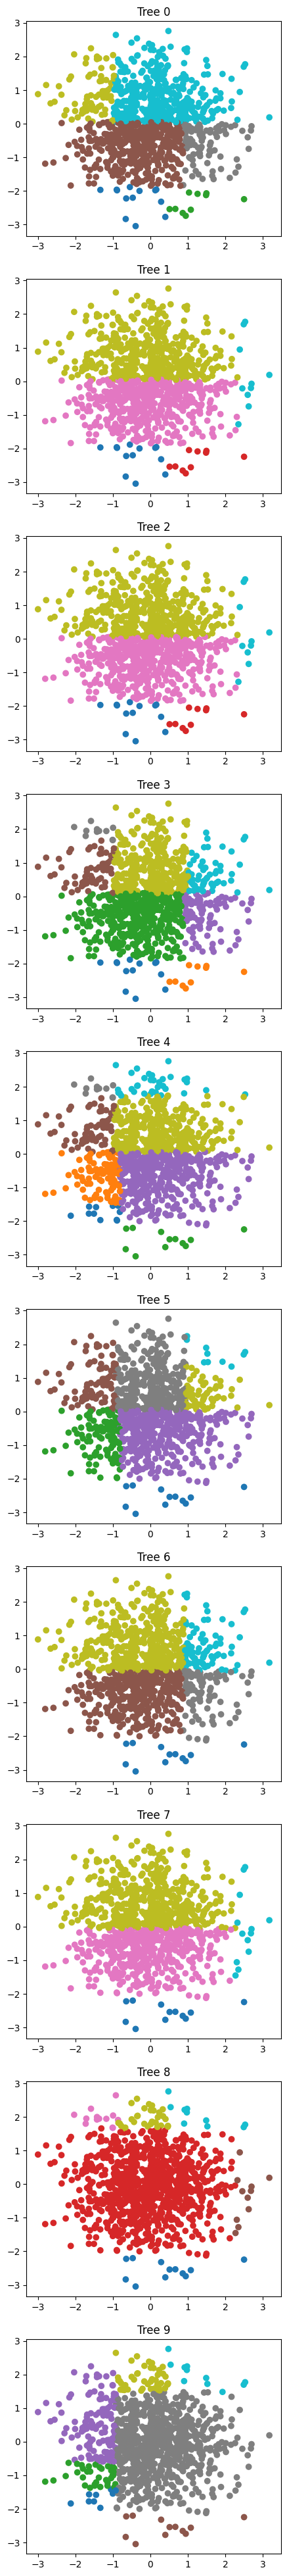

In [69]:
n_trees = len(model.trees)

fig, axs = plt.subplots(n_trees, 1, figsize=(5, 5 * n_trees))

for i, ax in enumerate(axs):
    index = model.trees[i].predict_index(x)

    ax.scatter(x[:, 0], x[:, 1], c=index, cmap="tab10")
    ax.set_title(f"Tree {i}")

plt.show()

In [ ]:
tree_idx = 2

predictions = model.trees[tree_idx].predict(x)
index = model.trees[tree_idx].predict_index(x)
colors = np.array(plt.get_cmap("tab10").colors)

# # Create a figure
# fig = go.Figure()

# # Add the first scatter plot
# # fig.add_trace(
# #     go.Scatter3d(x=x[:, 0], y=x[:, 1], z=y, mode="markers", marker=dict(color="red"))
# # )

# # Add the predictions
# fig.add_trace(
#     go.Scatter3d(
#         x=x[:, 0],
#         y=x[:, 1],
#         z=predictions,
#         mode="markers",
#         marker=dict(
#             color=colors[index]
#         ),  # Ensure colors[index] gives an array of colors
#     )
# )


# # Update the layout
# fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

# # Show the figure
# fig.show()